2026-02-21 18:07:42,718 - src.models.churn_model - INFO - Churn label distribution: {0: 2893, 1: 1445}
2026-02-21 18:07:42,720 - src.models.churn_model - INFO - Training random_forest model...
2026-02-21 18:07:48,584 - src.models.churn_model - INFO - Best parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
2026-02-21 18:07:48,602 - src.models.churn_model - INFO - Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       868
           1       1.00      1.00      1.00       434

    accuracy                           1.00      1302
   macro avg       1.00      1.00      1.00      1302
weighted avg       1.00      1.00      1.00      1302

2026-02-21 18:07:48,604 - src.models.churn_model - INFO - ROC-AUC Score: 1.0000
2026-02-21 18:07:48,611 - src.models.churn_model - INFO - Top 5 features:
Recency          0.777840
TenureDays       0.105328
Frequency        0.056968
Monetary         0.055314
Avg

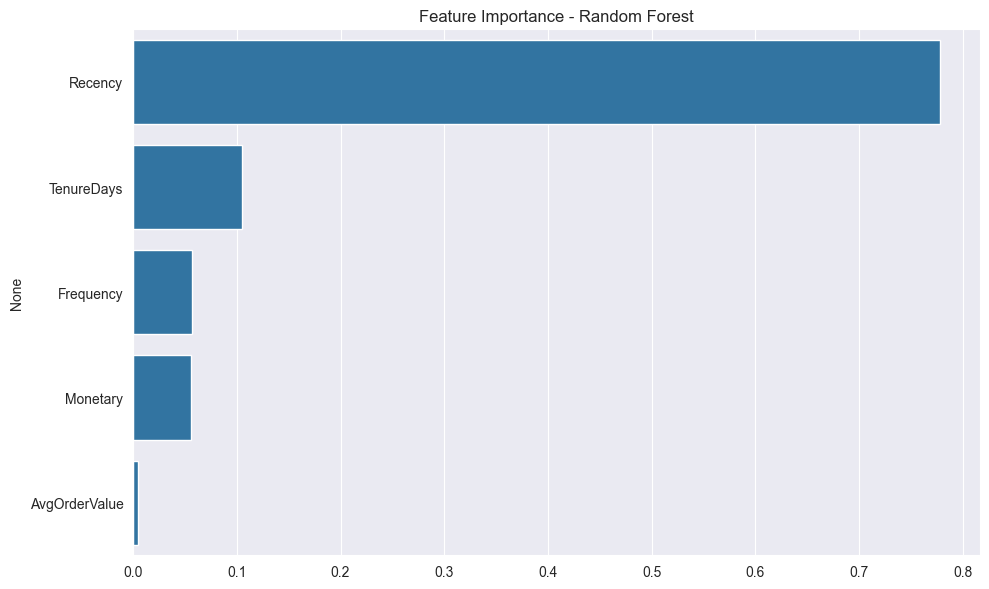

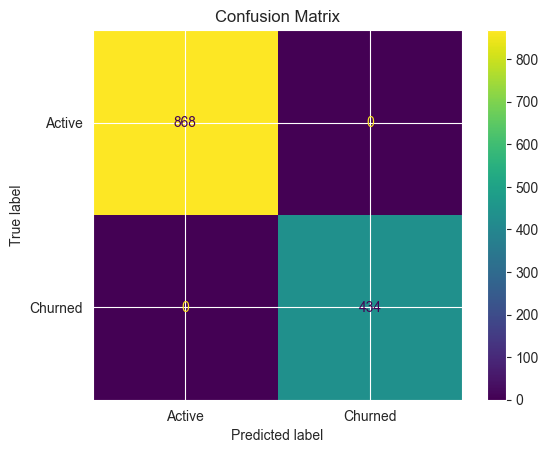

In [1]:
import sys
sys.path.append('..')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.features.build_features import build_all_features
from src.models.churn_model import (
    define_churn_labels, prepare_features_and_labels,
    train_churn_model, save_model
)
from src.utils.logger import setup_logger

logger = setup_logger('churn_modeling')

# Load data
df = pd.read_csv('../data/processed/cleaned_data.csv', parse_dates=['InvoiceDate'])
customer_features = pd.read_csv('../data/processed/customer_features.csv', index_col=0)

# Define churn labels (using last 90 days as churn window)
# We'll use the max date in data as reference
reference_date = df['InvoiceDate'].max()
churn_labels = define_churn_labels(df, customer_features, churn_window_days=90, reference_date=reference_date)

# Prepare features
X, y = prepare_features_and_labels(customer_features, churn_labels)

# Train model (you can experiment with both types)
model, X_train, X_test, y_train, y_test = train_churn_model(
    X, y, model_type='random_forest', tune_hyperparams=True
)

# Save model
save_model(model, '../models/churn_model_rf.pkl')

# (Optional) Try XGBoost as well
# model_xgb, _, _, _, _ = train_churn_model(X, y, model_type='xgboost', tune_hyperparams=True)
# save_model(model_xgb, '../models/churn_model_xgb.pkl')

# Visualize feature importance
importances = model.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title('Feature Importance - Random Forest')
plt.tight_layout()
plt.savefig('../reports/feature_importance.png')
plt.show()

# Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, model.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Active', 'Churned'])
disp.plot()
plt.title('Confusion Matrix')
plt.savefig('../reports/confusion_matrix.png')
plt.show()